# NLP_Projet Financial news sentiment analysis

<span style="color:magenta">Group members:</span>

* Junjie CHEN
* Pavlo Poliuha
* Pablo Molla 

In [157]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
import re
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import (
    decomposition,
    ensemble,
    linear_model,
    metrics,
    model_selection,
    multiclass,
    naive_bayes,
    neighbors,
    svm,
    tree,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from huggingface_hub import notebook_login
from sklearn import dummy, linear_model, metrics, preprocessing
from transformers import (
    AutoModel,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline,
)
from umap.umap_ import UMAP
import torch
from datasets import Dataset

In [2]:
columns=['Sentiment','text']
data = pd.read_csv('/Users/chenchenjunjie/M1_saclay/NLP/projet/Working_HNLP/Data_NLP.csv', encoding='ISO-8859-1',header=None, names=columns)

In [3]:
data

,Sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


In [4]:
labers = data['Sentiment']
labers.unique()

array(['neutral', 'negative', 'positive'], dtype=object)

## Data cleaning, change all the text to lower case, and preserve only words, remove all the sign

In [5]:
# change all the text to lower case
data['text'] = data['text'].apply(lambda x: x.lower())
data['text']

0       according to gran , the company has no plans t...
1       technopolis plans to develop in stages an area...
2       the international electronic industry company ...
3       with the new production plant the company woul...
4       according to the company 's updated strategy f...
                              ...                        
4841    london marketwatch -- share prices ended lower...
4842    rinkuskiai 's beer sales fell by 6.5 per cent ...
4843    operating profit fell to eur 35.4 mn from eur ...
4844    net sales of the paper segment decreased to eu...
4845    sales in finland decreased by 10.5 % in januar...
Name: text, Length: 4846, dtype: object

In [6]:
Sentiment_count=data.groupby('Sentiment').count()
Sentiment_count

,text
Sentiment,
negative,604
neutral,2879
positive,1363


In [7]:
def filter_alpha_tokens(tokens):
    # filter out non-alphabetic tokens
    return [token for token in tokens if token.isalpha()]

### Calculer chaque samble comprenant combien de tokens, et pour chaque sample comprenant combien de type de tokens<br>
 Use class nltk, word_tokenize 

In [8]:
data['word']=data['text'].apply(lambda x: filter_alpha_tokens(word_tokenize(x)))
data['word_n'] = data['word'].apply(len)
data

,Sentiment,text,word,word_n
0,neutral,"according to gran , the company has no plans t...","[according, to, gran, the, company, has, no, p...",22
1,neutral,technopolis plans to develop in stages an area...,"[technopolis, plans, to, develop, in, stages, ...",28
2,negative,the international electronic industry company ...,"[the, international, electronic, industry, com...",33
3,positive,with the new production plant the company woul...,"[with, the, new, production, plant, the, compa...",32
4,positive,according to the company 's updated strategy f...,"[according, to, the, company, updated, strateg...",28
...,...,...,...,...
4841,negative,london marketwatch -- share prices ended lower...,"[london, marketwatch, share, prices, ended, lo...",23
4842,neutral,rinkuskiai 's beer sales fell by 6.5 per cent ...,"[rinkuskiai, beer, sales, fell, by, per, cent,...",22
4843,negative,operating profit fell to eur 35.4 mn from eur ...,"[operating, profit, fell, to, eur, mn, from, e...",17
4844,negative,net sales of the paper segment decreased to eu...,"[net, sales, of, the, paper, segment, decrease...",35


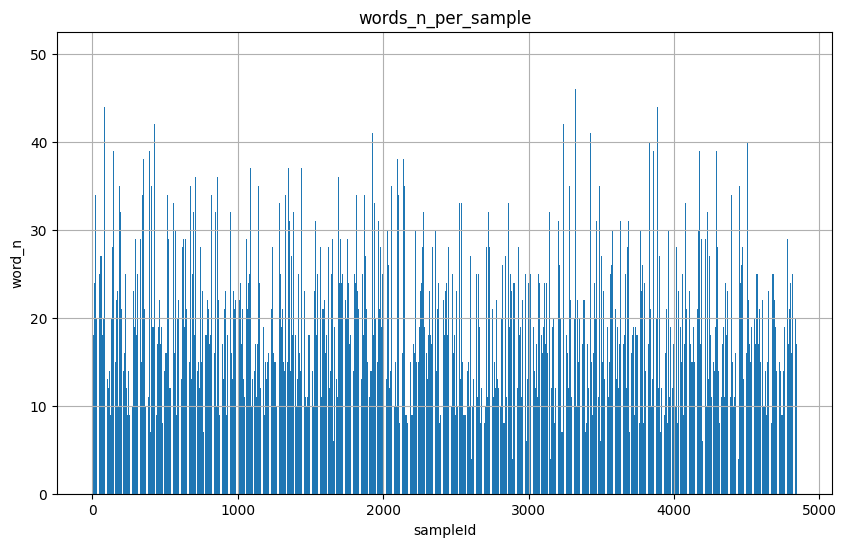

In [9]:
plt.figure(figsize=(10, 6))  
plt.bar(data.index, data['word_n']) 
plt.title('words_n_per_sample')  
plt.xlabel('sampleId')  
plt.ylabel('word_n')  
plt.grid(True)  
plt.show()  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


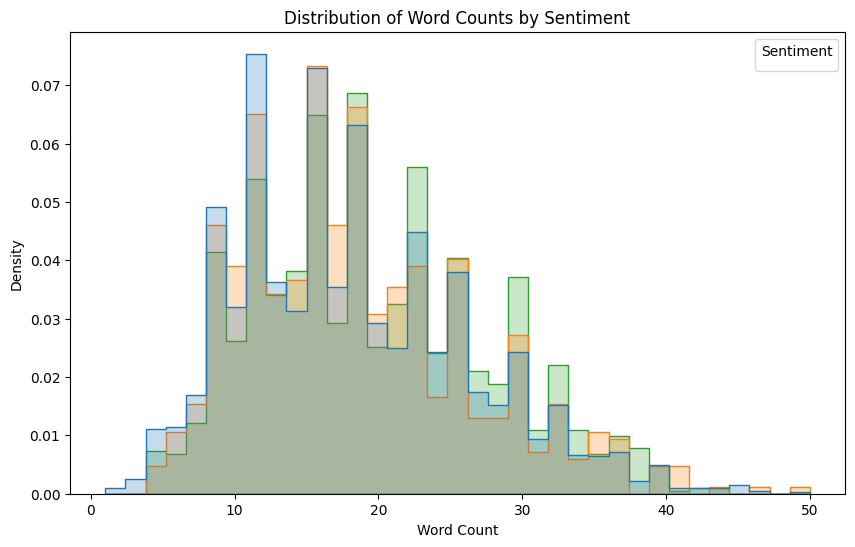

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='word_n', hue='Sentiment', element="step", stat="density", common_norm=False)
plt.title('Distribution of Word Counts by Sentiment')
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.legend(title='Sentiment')
plt.show()

## Count the total number of three types of samples, the total number of words, the number of words without repetition

In [11]:
# combine all the text for each class
grouped_text = data.groupby('Sentiment')['text'].agg(lambda texts: ' '.join(texts))

# calculate the total number of tokens in each class use word_tokenize
word_counts = grouped_text.apply(lambda x: len(filter_alpha_tokens(word_tokenize(x))))
#plot tokens in each class
words_n = grouped_text.apply(lambda x: filter_alpha_tokens(word_tokenize(x)))
# calculate the total number of unique tokens in each class
unique_word_counts = grouped_text.apply(lambda x: len(set(filter_alpha_tokens(word_tokenize(x)))))


# results combined into a single dataframe
summary_df = pd.DataFrame({
    'sample_n': Sentiment_count['text'],
    'chars_n': grouped_text.apply(len),
    'total_words': word_counts,
    'unique_words': unique_word_counts,
    'text': grouped_text,
    'words': words_n
})
summary_df


,sample_n,chars_n,total_words,unique_words,text,words
Sentiment,,,,,,
negative,604,76560,11161,1932,the international electronic industry company ...,"[the, international, electronic, industry, com..."
neutral,2879,362961,52161,6922,"according to gran , the company has no plans t...","[according, to, gran, the, company, has, no, p..."
positive,1363,186250,26763,4006,with the new production plant the company woul...,"[with, the, new, production, plant, the, compa..."


Visualizing the corpus

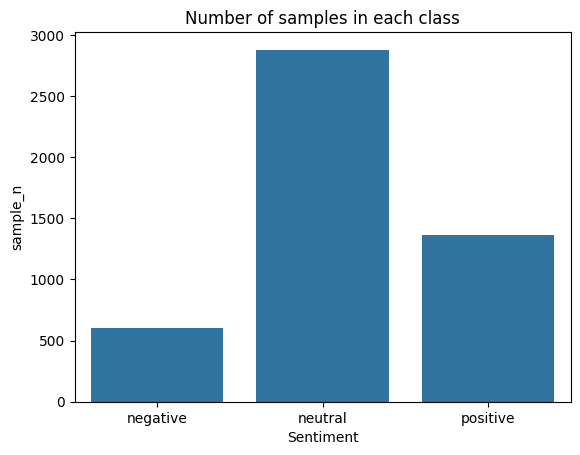

In [12]:
sns.barplot(x=summary_df.index, y=summary_df['sample_n'])
plt.title('Number of samples in each class')
plt.show()

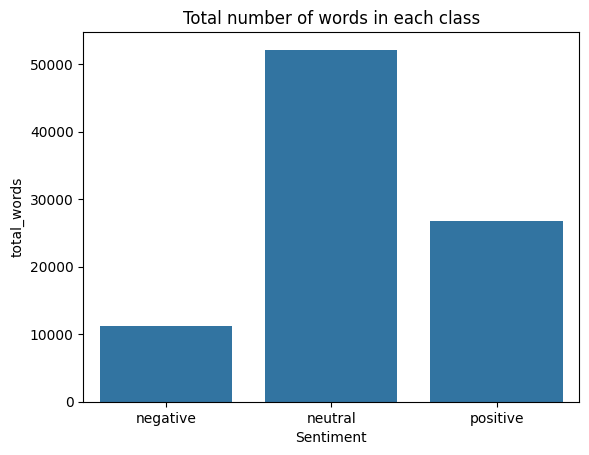

In [13]:
sns.barplot(x=summary_df.index, y=summary_df['total_words'])
plt.title('Total number of words in each class')
plt.show()

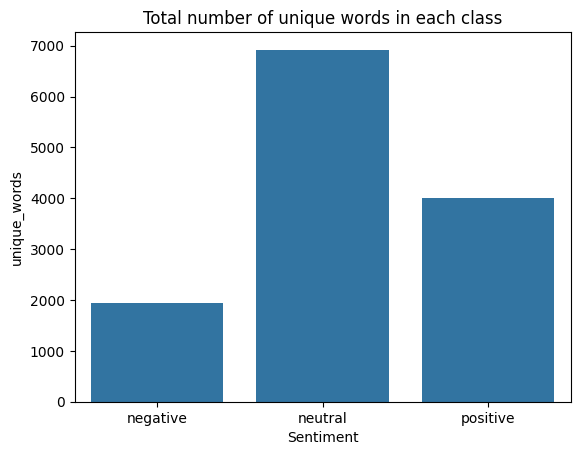

In [14]:
sns.barplot(x=summary_df.index, y=summary_df['unique_words'])
plt.title('Total number of unique words in each class')
plt.show()

## Calculate the frequency of word for every class

In [15]:
def all_token_freq(tokens):
    #filter all the words including digits and special character
    filtered_tokens = {token : count for token,count in tokens.items() if not re.search(r"[0-9/=+\._-]", token)}
    return filtered_tokens or None

all_word_freqs_df = summary_df["words"].apply(lambda x : Counter(x)).to_frame()
all_word_freqs_df

,words
Sentiment,
negative,"{'the': 759, 'international': 4, 'electronic':..."
neutral,"{'according': 78, 'to': 1228, 'gran': 1, 'the'..."
positive,"{'with': 201, 'the': 1587, 'new': 82, 'product..."


In [16]:
def plot_top_words_subplots(token_freqs_df, top_n=10):
    # create a figure and a set of subplots
    fig, axes = plt.subplots(1, 3, figsize=(30, 10))
    plt.tight_layout(pad=6.0)
    # iterate over the rows of the dataframe
    for ax, (sentiment, row) in zip(axes, token_freqs_df.iterrows()):
        # filter the tokens
        filtered_tokens = all_token_freq(row['words'])
        
        #  sort the tokens by frequency and select the top n
        top_tokens = dict(sorted(filtered_tokens.items(), key=lambda item: item[1], reverse=True)[:top_n])
        
        # plot the top tokens
        ax.bar(top_tokens.keys(), top_tokens.values(), color='skyblue')
        ax.set_xlabel('Word')
        ax.set_ylabel('Frequency')
        ax.set_title(f'Top {top_n} words in {sentiment.capitalize()} Sentiment')
        ax.tick_params(axis='x', rotation=90)

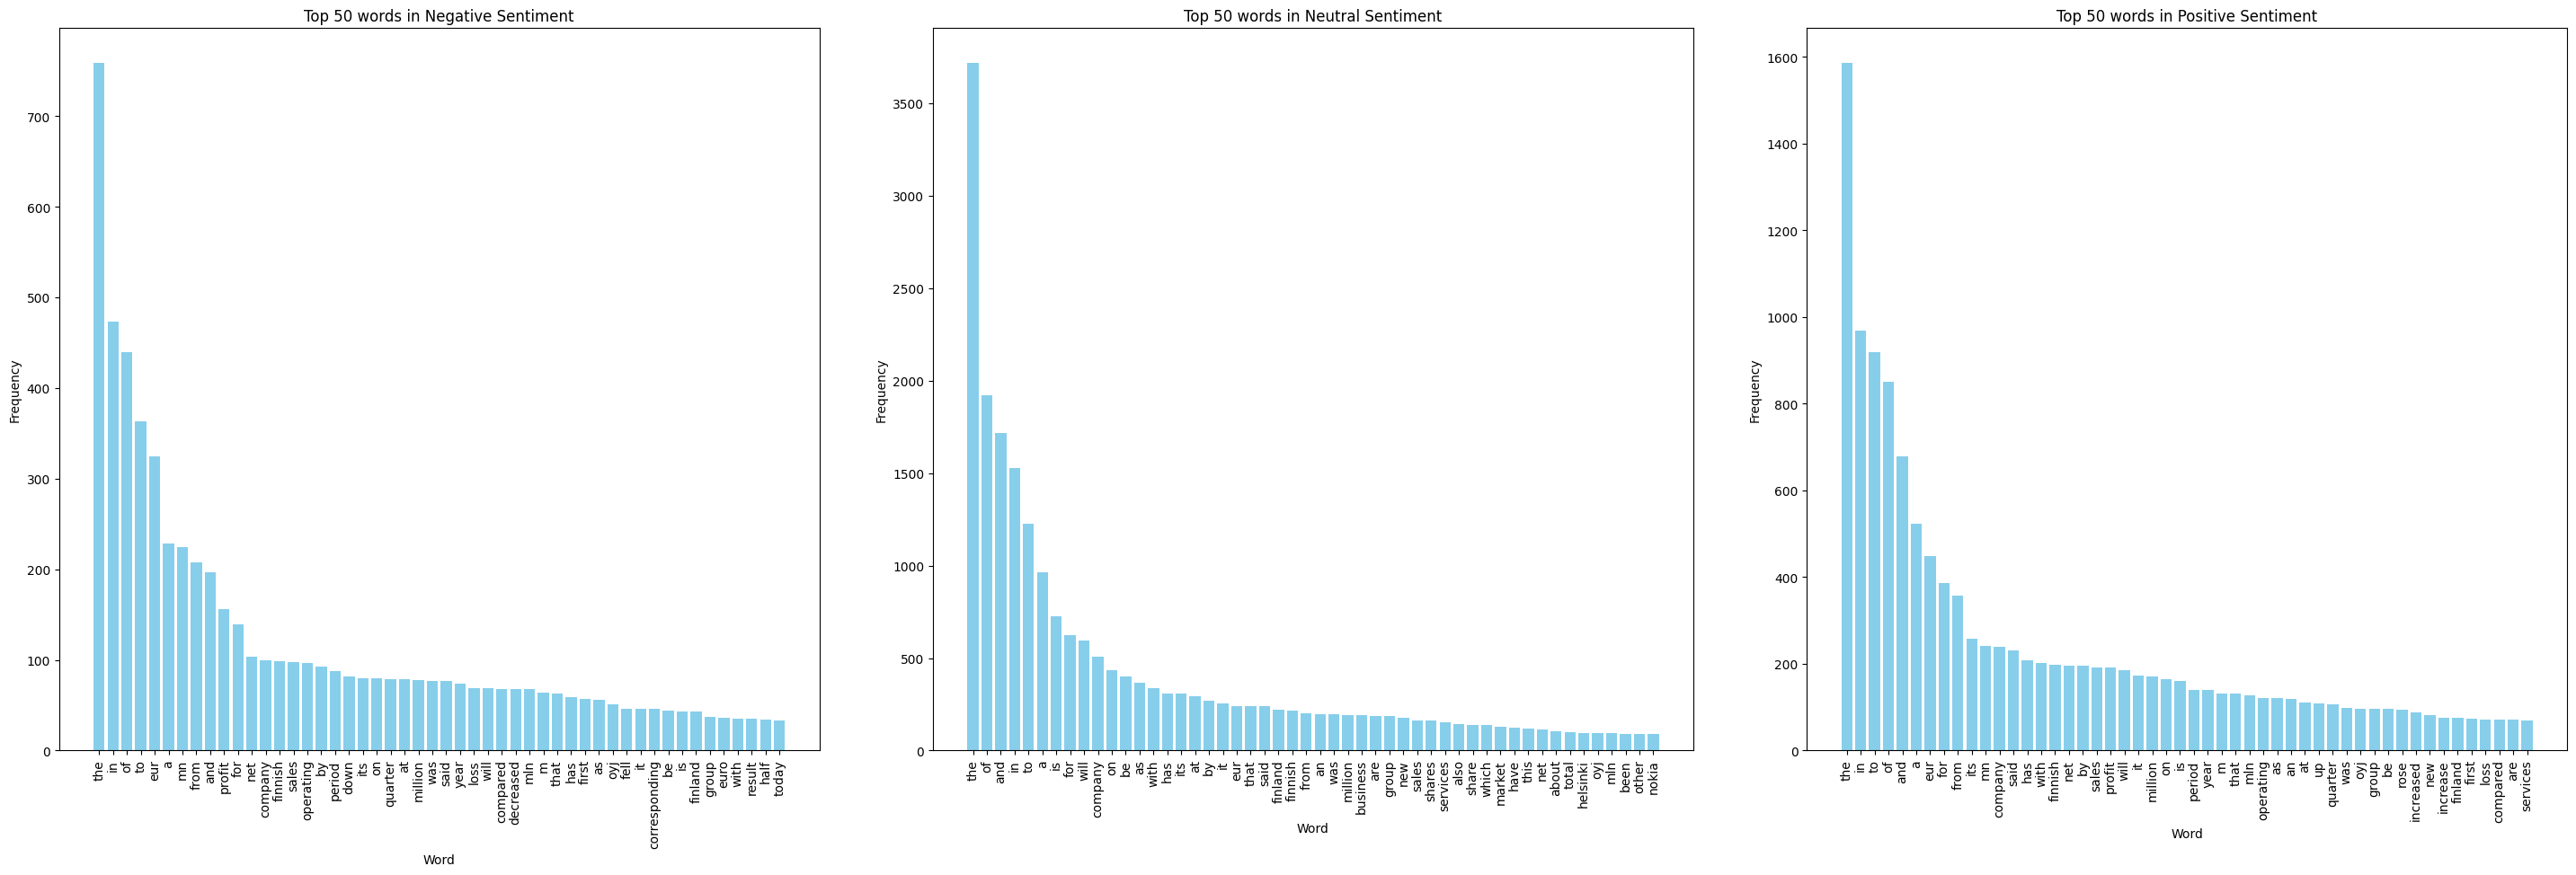

In [17]:
plot_top_words_subplots(all_word_freqs_df, top_n=50)
# we find word 'decrease' in negative sentiment, and word 'increase' is the most frequent word in positive sentiment

The richness of words in each category was analyzed as the sample increased

In [18]:
def batch_counts(text,maxlen,hop):
    counters = [Counter()]
    words = word_tokenize(text)
    for i in range(0, maxlen, hop):
        batch_words = words[:i + hop]
        counters.append(Counter(batch_words))
    # return the counts for each batch
    return [len(cntr) for cntr in counters]

Sentiment
negative    [0, 73, 123, 169, 201, 220, 239, 255, 287, 323...
neutral     [0, 70, 131, 182, 225, 268, 311, 356, 395, 429...
positive    [0, 66, 103, 157, 195, 231, 271, 302, 337, 356...
Name: text, dtype: object


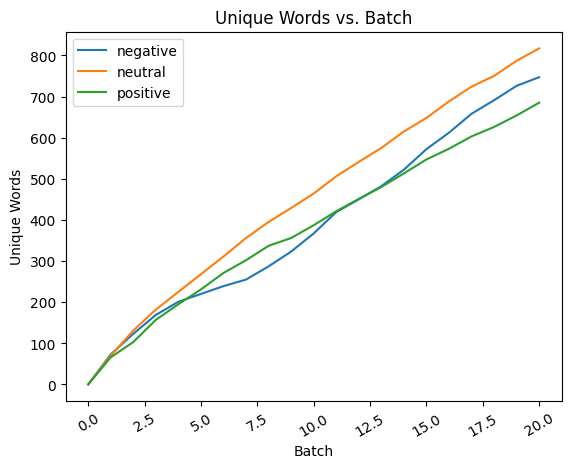

In [19]:
HOP = 100
batch_counters = summary_df.text.map(
    lambda x: batch_counts(x,summary_df.unique_words.min(),hop=HOP)
)
print(batch_counters)
batch_counters_df = pd.DataFrame(
    batch_counters.tolist(),
    index=summary_df.index
)
batch_counters_df.T.plot(legend=False)
plt.xticks(rotation=30)
plt.xlabel('Batch')
plt.ylabel('Unique Words')
plt.title('Unique Words vs. Batch')
plt.legend()
plt.show()

## Boxplot the number of words per class sentiment

<Figure size 1000x600 with 0 Axes>

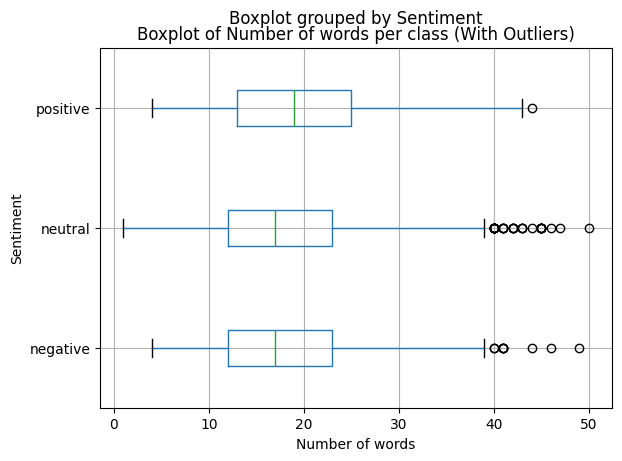

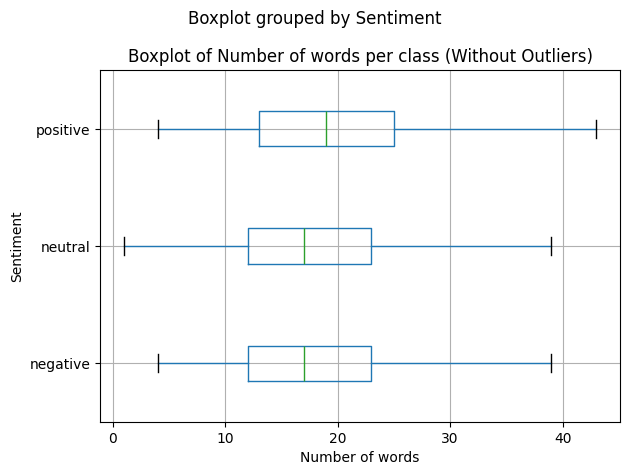

In [20]:
# Draw a box diagram containing outliers
plt.figure(figsize=(10, 6))

data.boxplot(column='word_n', by='Sentiment',vert=False, showfliers=True)
plt.title('Boxplot of Number of words per class (With Outliers)')
plt.xlabel('Number of words')

# Draw a box diagram that does not contain outliers

data.boxplot(column='word_n',by='Sentiment',vert=False, showfliers=False)
plt.title('Boxplot of Number of words per class (Without Outliers)')
plt.xlabel('Number of words')

plt.tight_layout()
plt.show()

## Firstly, we use Converved CountVectorize  and wordVectorize with a basic Machine learning algo ( Logisteric Regression ) for predict.

In [21]:
data

,Sentiment,text,word,word_n
0,neutral,"according to gran , the company has no plans t...","[according, to, gran, the, company, has, no, p...",22
1,neutral,technopolis plans to develop in stages an area...,"[technopolis, plans, to, develop, in, stages, ...",28
2,negative,the international electronic industry company ...,"[the, international, electronic, industry, com...",33
3,positive,with the new production plant the company woul...,"[with, the, new, production, plant, the, compa...",32
4,positive,according to the company 's updated strategy f...,"[according, to, the, company, updated, strateg...",28
...,...,...,...,...
4841,negative,london marketwatch -- share prices ended lower...,"[london, marketwatch, share, prices, ended, lo...",23
4842,neutral,rinkuskiai 's beer sales fell by 6.5 per cent ...,"[rinkuskiai, beer, sales, fell, by, per, cent,...",22
4843,negative,operating profit fell to eur 35.4 mn from eur ...,"[operating, profit, fell, to, eur, mn, from, e...",17
4844,negative,net sales of the paper segment decreased to eu...,"[net, sales, of, the, paper, segment, decrease...",35


In [22]:
ys = data['Sentiment']
ys

0        neutral
1        neutral
2       negative
3       positive
4       positive
          ...   
4841    negative
4842     neutral
4843    negative
4844    negative
4845    negative
Name: Sentiment, Length: 4846, dtype: object

In [23]:
vectorizer = CountVectorizer()
# convert the array of words into a single string
text_data = [" ".join(text) for text in data['word']]
xs = vectorizer.fit_transform(text_data)
vectorizer.get_feature_names_out()

array(['aaland', 'aalborg', 'aalto', ..., 'zoo', 'zte', 'zu'],
      dtype=object)

In [24]:
cv_df = pd.DataFrame(xs.toarray(), columns=vectorizer.get_feature_names_out())
cv_df.set_index(data.index, inplace=True)
cv_df

,aaland,aalborg,aalto,aaltonen,aaron,aava,aazhang,ab,abb,abbott,...,zero,zgody,zinc,zip,zloty,zoltan,zone,zoo,zte,zu
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4841,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4842,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4843,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4844,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
train_xs, test_xs, train_ys, test_ys = train_test_split(
    xs, ys, test_size=0.2, random_state=0, shuffle=True
)
print(train_xs.shape)
print(test_xs.shape)

(3876, 8657)
(970, 8657)


logistic Accuracy: 0.77
              precision    recall  f1-score   support

    negative       0.79      0.51      0.62       128
     neutral       0.78      0.90      0.84       575
    positive       0.73      0.62      0.67       267

    accuracy                           0.77       970
   macro avg       0.77      0.68      0.71       970
weighted avg       0.77      0.77      0.76       970



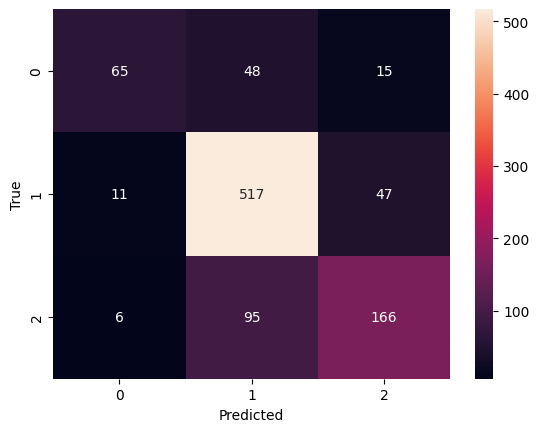

In [26]:
# This part is about the vectorization with basic machine learning model
logistic_regression_model = LogisticRegression(max_iter=1000)
logistic_regression_model.fit(train_xs, train_ys)
pred_ys = logistic_regression_model.predict(test_xs)
accuracy = logistic_regression_model.score(test_xs, test_ys)
print(f'logistic Accuracy: {accuracy:.2f}')
print(classification_report(test_ys, pred_ys))
# print the confusion matrix
cm = confusion_matrix(test_ys, pred_ys)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### use TFidVectorizer with a basic machine learning (logistic) model


In [27]:
# This part is about the vectorization with basic machine learning model
transformer = TfidfVectorizer()
xs_tf = transformer.fit_transform(text_data).toarray()

tf_idf = pd.DataFrame(xs_tf, index=data.index, columns=transformer.get_feature_names_out()) # create a dataframe from the tf-idf matrix
tf_idf



,aaland,aalborg,aalto,aaltonen,aaron,aava,aazhang,ab,abb,abbott,...,zero,zgody,zinc,zip,zloty,zoltan,zone,zoo,zte,zu
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


TfidfVectorizer with logisticRegression Accuracy: 0.7618556701030927
TfidfVectorizer Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.39      0.53       128
     neutral       0.75      0.95      0.84       575
    positive       0.79      0.53      0.63       267

    accuracy                           0.76       970
   macro avg       0.80      0.62      0.67       970
weighted avg       0.77      0.76      0.74       970



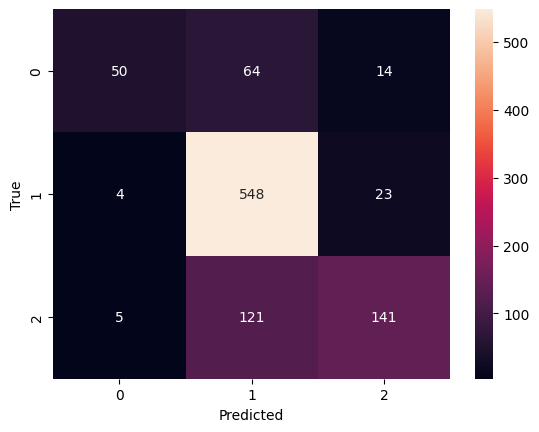

In [28]:
clf_tfidf = LogisticRegression(max_iter=1000)
train_x_tf, test_x_tf, train_ys_tf, test_ys_tf = train_test_split(
    xs_tf, ys, test_size=0.2, random_state=0, shuffle=True
)
clf_tfidf.fit(train_x_tf, train_ys_tf)
pred_ys_tf = clf_tfidf.predict(test_x_tf)
print("TfidfVectorizer with logisticRegression Accuracy:", accuracy_score(test_ys_tf, pred_ys_tf))
print("TfidfVectorizer Classification Report:")
print(classification_report(test_ys_tf, pred_ys_tf))
# print the confusion matrix
cm = confusion_matrix(test_ys_tf, pred_ys_tf)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Now, we use word2vec with logistic regression classifateur
### Extract features using Word2Vec embeddings: We'll use the Gensim library to access pre-trained Word2Vec embeddings to convert the text into vectors.
### Train a basic ML model: We'll train a Logistic Regression model, which is a good starting point for classification tasks.

In [29]:
model_w2v = Word2Vec(sentences=data['text'], vector_size=100, window=5, min_count=1, workers=4)
# obtain the word vectors
def document_vector(word_list):
    # remove out-of-vocabulary words
    word_list = [word for word in word_list if word in model_w2v.wv.index_to_key]
    if len(word_list) == 0:
        return np.zeros(100)
    # calculate the mean of the word vectors
    return np.mean(model_w2v.wv[word_list], axis=0)

# apply the function to the text column
data['Vec'] = data['text'].apply(document_vector)

X_wd2 = np.array(list(data['Vec'])) # eigenvector
y_wd2 = data['Sentiment'] # target

              precision    recall  f1-score   support

    negative       0.53      0.07      0.13       110
     neutral       0.64      0.98      0.77       571
    positive       0.60      0.17      0.26       289

    accuracy                           0.63       970
   macro avg       0.59      0.41      0.39       970
weighted avg       0.62      0.63      0.55       970



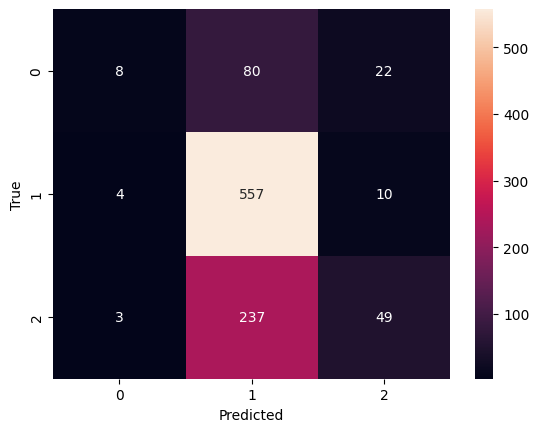

In [30]:
# split dataset into training and testing set
X_train_wd2, X_test_wd2, y_train_wd2, y_test_wd2 = train_test_split(X_wd2, y_wd2, test_size=0.2, random_state=42)

# use logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_wd2, y_train_wd2)

# evaluate the model
y_pred_wd2 = model.predict(X_test_wd2)
print(classification_report(y_test_wd2, y_pred_wd2 ))
# print the confusion matrix
cm = confusion_matrix(y_test_wd2, y_pred_wd2)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Use doc2CV model  and logistic regression

In [31]:
#Train a Doc2Vec model
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(data['word'])]
model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)

# Extract the vectors
def vector_for_document(model, doc):
    return model.infer_vector(doc)

x_doc2= np.array([vector_for_document(model, doc) for doc in data['word']])
y_doc2 = data['Sentiment'].values

# train the classifier
X_train_doc2, X_test_doc2, y_train_doc2, y_test_doc2 = train_test_split(x_doc2, y_doc2, test_size=0.2, random_state=42)
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train_doc2, y_train_doc2)

y_pred_doc2 = classifier.predict(X_test_doc2)
print(classification_report(y_test_doc2, y_pred_doc2))

              precision    recall  f1-score   support

    negative       0.30      0.03      0.05       110
     neutral       0.62      0.96      0.75       571
    positive       0.47      0.13      0.21       289

    accuracy                           0.61       970
   macro avg       0.46      0.37      0.34       970
weighted avg       0.54      0.61      0.51       970



### Conclusion for the baseline approach ( use 3 baseline approach ), the accuracy : Countvectorize >  TFidVectorize   > word2CV > doc2CV 
0.77 > 0.76 > 0.64 > 0.60

## This part, we begin to use a second, more expressive baseline with Transformers as feature extraction only and the same basic ML algorithms ( logistic regression ), use ( DistilBERT model)

In [34]:
## Using gpu acceleration
print(torch.backends.mps.is_available()) #the MacOS is higher than 12.3+
print(torch.backends.mps.is_built()) #MPS is activated
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda")

True
True


In [35]:
df = data[['Sentiment','text']]
df['Sentiment'] = df['Sentiment'].map({'positive': 1, 'neutral': 0, 'negative': -1})
df

/var/folders/tt/pf5xh4vs14v9h68lqh4py2s00000gn/T/ipykernel_43372/4073224333.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentiment'] = df['Sentiment'].map({'positive': 1, 'neutral': 0, 'negative': -1})


,Sentiment,text
0,0,"according to gran , the company has no plans t..."
1,0,technopolis plans to develop in stages an area...
2,-1,the international electronic industry company ...
3,1,with the new production plant the company woul...
4,1,according to the company 's updated strategy f...
...,...,...
4841,-1,london marketwatch -- share prices ended lower...
4842,0,rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,-1,operating profit fell to eur 35.4 mn from eur ...
4844,-1,net sales of the paper segment decreased to eu...


In [36]:
# load the pre-trained model distilbert, and the tokenizer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
# move the model to the device
model.to(device)

texts = data['text'].tolist()
labels = data['Sentiment'].map({'positive': 1, 'neutral': 0, 'negative': -1}).tolist()

# use gpu boost to extract features
def extract_features(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=50, return_tensors="pt")
    inputs = inputs.to(device)  # move the input tensors to the device
    with torch.no_grad():
        outputs = model(**inputs)
    # return the first token of the last hidden state
    return outputs.last_hidden_state[:, 0, :].cpu().numpy()

#features = extract_features(texts)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [37]:
# Word segmentation is performed on the data set
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=50)
tokenized_data = df.apply(tokenize_function, axis=1)
tokenized_df = pd.DataFrame(tokenized_data.tolist())  # if result is a DataFrame
tokenized_df[['label','text']] = df[['Sentiment','text']]
tokenized_df

,attention_mask,input_ids,label,text
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 2429, 2000, 12604, 1010, 1996, 2194, 203...",0,"according to gran , the company has no plans t..."
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 21416, 17699, 3488, 2000, 4503, 1999, 57...",0,technopolis plans to develop in stages an area...
2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 1996, 2248, 4816, 3068, 2194, 3449, 1980...",-1,the international electronic industry company ...
3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 2007, 1996, 2047, 2537, 3269, 1996, 2194...",1,with the new production plant the company woul...
4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 2429, 2000, 1996, 2194, 1005, 1055, 7172...",1,according to the company 's updated strategy f...
...,...,...,...,...
4841,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 2414, 3006, 18866, 1011, 1011, 3745, 759...",-1,london marketwatch -- share prices ended lower...
4842,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 18416, 2271, 21128, 2072, 1005, 1055, 54...",0,rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 4082, 5618, 3062, 2000, 7327, 2099, 3486...",-1,operating profit fell to eur 35.4 mn from eur ...
4844,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 5658, 4341, 1997, 1996, 3259, 6903, 1054...",-1,net sales of the paper segment decreased to eu...


In [67]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {
        k: torch.tensor(v).to(device) for k, v in batch.items()
        if k in tokenizer.model_input_names
    }
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

In [149]:
# convert the dataframe to a dataset of huggingface
emotions = Dataset.from_pandas(tokenized_df)
# split the dataset into training and testing set
emotions_data = emotions.train_test_split(test_size=0.2)

In [78]:
emotions_hidden = emotions_data.map(extract_hidden_states, batched=True)

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [79]:
emotions_hidden['train'].column_names

['attention_mask', 'hidden_state', 'input_ids', 'label', 'text']

In [99]:
train_xs = np.array(emotions_hidden["train"]["hidden_state"])
test_xs = np.array(emotions_hidden["test"]["hidden_state"])
train_ys = np.array(emotions_hidden["train"]["label"])
test_ys = np.array(emotions_hidden["test"]["label"])
train_xs.shape, test_xs.shape

((3876, 768), (970, 768))

In [100]:
label_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
# Scale features to [0,1] range
scaled_xs = preprocessing.MinMaxScaler().fit_transform(train_xs)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(scaled_xs)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = train_ys
df_emb.head()

,X,Y,label
0,12.707244,3.408781,0
1,12.580527,5.586787,0
2,11.885259,3.806142,0
3,7.709240,2.709152,1
4,8.011144,2.489262,1


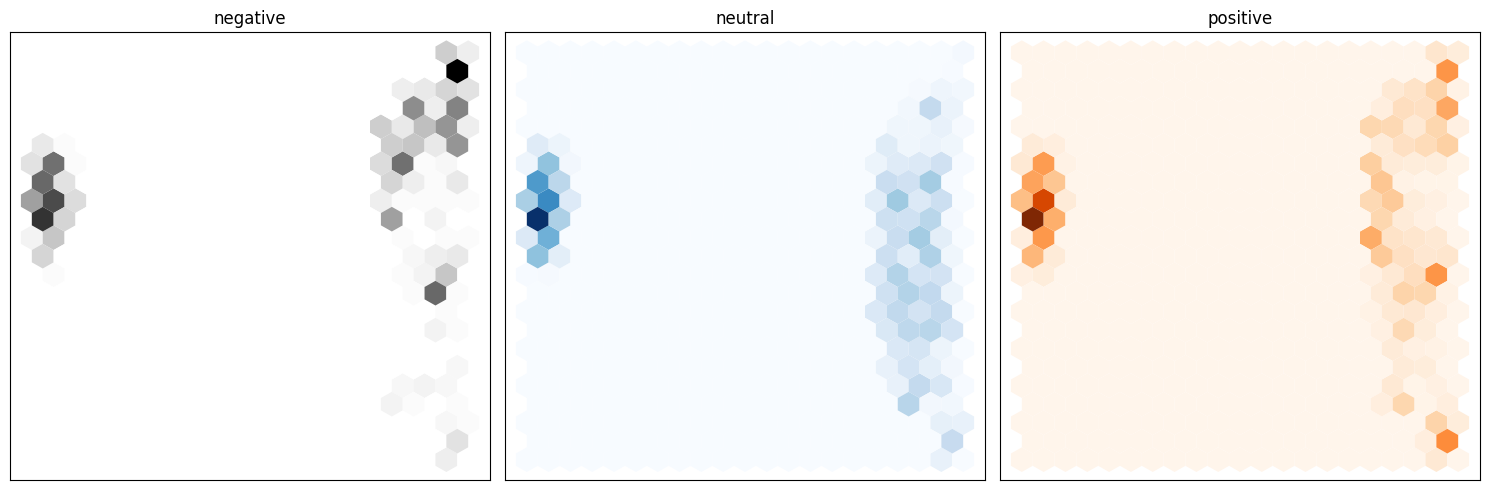

In [96]:
labels = [ 'negative','neutral', 'positive']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges"]

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i-1}")
    axes[i].hexbin(
        df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,)
    )
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

#### From this plot we can see some clear patterns:  in total,  we can find that they have slight similarities, negative picture shows that they occupy on the left and on the right above. on the otherhand, positive picture shows that they also occupy on the left but in the right, they occupy meanly. Finally, for neutral, they occupy mainly on the left.


In [ ]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = metrics.confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

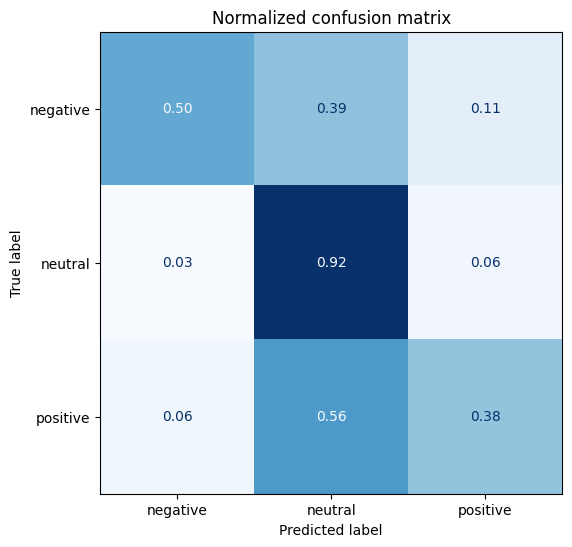

              precision    recall  f1-score   support

          -1       0.61      0.50      0.55       107
           0       0.72      0.92      0.81       573
           1       0.72      0.38      0.50       290

    accuracy                           0.71       970
   macro avg       0.68      0.60      0.62       970
weighted avg       0.71      0.71      0.69       970



In [143]:
# train the model
classifier = LogisticRegression(max_iter=1000)
classifier.fit(train_xs, train_ys)

# evaluate the model
pred_ys = classifier.predict(test_xs)
plot_confusion_matrix(pred_ys, test_ys, labels)
print(classification_report(test_ys, pred_ys))
# cm = confusion_matrix(test_ys, pred_ys)
# sns.heatmap(cm, annot=True, fmt='g')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()

In [103]:
dummy_clf = dummy.DummyClassifier(strategy="most_frequent")
dummy_clf.fit(train_xs, train_ys)
dummy_clf.score(test_xs,test_ys)

0.5907216494845361

Looking at the accuracy, it might appear that our model is just a bit better than random—but since we are dealing with an unbalanced multiclass dataset, it's actually significantly better. We can examine whether our model is any good by comparing it against a simple baseline. In Scikit-Learn there is a DummyClassifier that can be used to build a classifier with simple heuristics such as always choosing the majority class or always drawing a random class. In this case the best-performing heuristic is to always choose the most frequent class, which yields an accuracy of about 35%

### expressive baseline with Transformers as feature extraction only , the accuracy is 0.80+-0.1, the model is best so far

## Third part : Use a more comprehensive approach with a Transformers model that you fine-tuned on our data.

#### Loading a pretrained model
The first thing we need is a pretrained DistilBERT model like the one we used in the feature-based approach. The only slight modification is that we use the AutoModelForSequenceClassification model instead of AutoModel. The difference is that the AutoModelForSequenceClassification model has a classification head on top of the pretrained model outputs, which can be easily trained with the base model. We just need to specify how many labels the model has to predict (six in our case), since this dictates the number of outputs the classification head has:

In [174]:
num_labels = 3
model_name = "distilbert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=num_labels
).to(device)

#### Defining the performance metrics
To monitor metrics during training, we need to define a compute_metrics() function for the Trainer. This function receives an EvalPrediction object (which is a named tuple with predictions and label_ids attributes) and needs to return a dictionary that maps each metric's name to its value. For our application, we'll compute the  F1-score and the accuracy of the model as follows:

In [145]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = metrics.f1_score(labels, preds, average="weighted")
    acc = metrics.accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [175]:
batch_size = 30
logging_steps = len(emotions_data['train']) // batch_size
model_name2 = f"{model_name}-finetuned-emotion"
training_args = TrainingArguments(
    output_dir=f"./{model_name2}",
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,  # True
    log_level="error",
)

In [151]:
def adjust_labels(example):
    example['label'] += 1
    return example

emotions_data['train'] = emotions_data['train'].map(adjust_labels)
emotions_data['test'] = emotions_data['test'].map(adjust_labels)

  0%|          | 0/3876 [00:00<?, ?ex/s]

  0%|          | 0/970 [00:00<?, ?ex/s]

In [176]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_data["train"],
    eval_dataset=emotions_data["test"],
    tokenizer=tokenizer,
)
trainer.train()
# save the model and the tokenizer
model.save_pretrained(f"./{model_name2}")
tokenizer.save_pretrained(f"./{model_name2}")

/Users/chenchenjunjie/anaconda3/envs/nlp/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/260 [00:00<?, ?it/s]

{'loss': 0.6508, 'learning_rate': 1.0076923076923078e-05, 'epoch': 0.99}


  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.4528653621673584, 'eval_accuracy': 0.811340206185567, 'eval_f1': 0.8110439422250081, 'eval_runtime': 8.2835, 'eval_samples_per_second': 117.101, 'eval_steps_per_second': 3.984, 'epoch': 1.0}
{'loss': 0.3609, 'learning_rate': 1.5384615384615387e-07, 'epoch': 1.98}


  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.42901861667633057, 'eval_accuracy': 0.8206185567010309, 'eval_f1': 0.8205092181873613, 'eval_runtime': 7.5833, 'eval_samples_per_second': 127.912, 'eval_steps_per_second': 4.352, 'epoch': 2.0}
{'train_runtime': 214.3195, 'train_samples_per_second': 36.17, 'train_steps_per_second': 1.213, 'train_loss': 0.5048114620722257, 'epoch': 2.0}


('./distilbert-base-uncased-finetuned-emotion/tokenizer_config.json',
 './distilbert-base-uncased-finetuned-emotion/special_tokens_map.json',
 './distilbert-base-uncased-finetuned-emotion/vocab.txt',
 './distilbert-base-uncased-finetuned-emotion/added_tokens.json',
 './distilbert-base-uncased-finetuned-emotion/tokenizer.json')

In [177]:
preds_output = trainer.predict(emotions_data["test"])

  0%|          | 0/33 [00:00<?, ?it/s]

In [178]:
preds_output.metrics

{'test_loss': 0.42901861667633057,
 'test_accuracy': 0.8206185567010309,
 'test_f1': 0.8205092181873613,
 'test_runtime': 7.6119,
 'test_samples_per_second': 127.432,
 'test_steps_per_second': 4.335}

In [179]:
y_preds = np.argmax(preds_output.predictions, axis=1)
# convert the labels back to the original values
y_preds = np.array([label - 1 for label in y_preds])


In [190]:
model_id = f"/Users/chenchenjunjie/M1_saclay/NLP/projet/Working_HNLP/{model_name2}"
classifier = pipeline("text-classification", model=model_id)

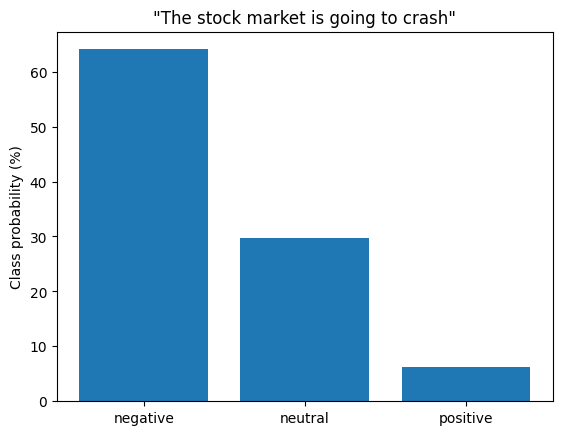

In [191]:
Title_news = "The stock market is going to crash"
preds = classifier(Title_news, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color="C0")
plt.title(f'"{Title_news}"')
plt.ylabel("Class probability (%)")
plt.show()

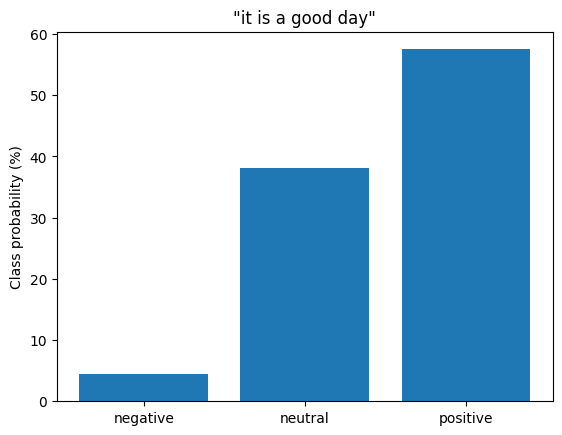

In [192]:
Title_news = "it is a good day"
preds = classifier(Title_news, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color="C0")
plt.title(f'"{Title_news}"')
plt.ylabel("Class probability (%)")
plt.show()

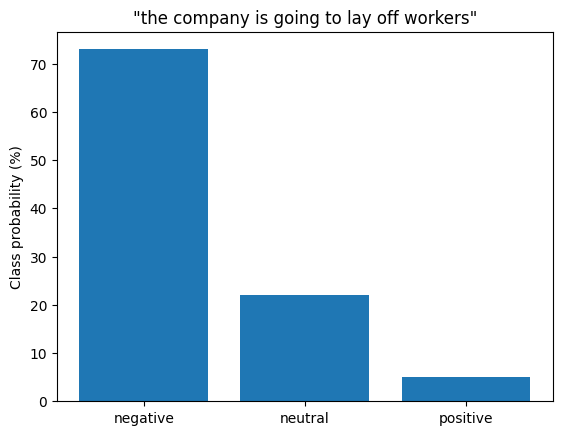

In [193]:
Title_news = "the company is going to lay off workers"
preds = classifier(Title_news, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color="C0")
plt.title(f'"{Title_news}"')
plt.ylabel("Class probability (%)")
plt.show()

## Conclusion
In general,